In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
data = pd.read_csv("dataset/anaemia.csv")

In [4]:
data['Sex'] = data['Sex'].str.strip()

missing_values = data.isnull().sum()

duplicates = data.duplicated().sum()
data = data.drop_duplicates()

In [5]:
encoder = LabelEncoder()

data['Sex'] = encoder.fit_transform(data['Sex'])

data['Anaemic'] = encoder.fit_transform(data['Anaemic'])

In [26]:
data["Anaemic"]

0      1
1      0
2      0
3      0
4      0
      ..
99     1
100    1
101    0
102    0
103    0
Name: Anaemic, Length: 104, dtype: int64

In [7]:
X = data[['Sex', '%Red Pixel', '%Green pixel', '%Blue pixel', 'Hb']]
y = data['Anaemic']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for SVM
scaler = StandardScaler()

In [8]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)

In [9]:
svm_model.fit(X_train_scaled, y_train)

SVC(C=1, random_state=42)

In [10]:
svm_predictions = svm_model.predict(X_test_scaled)

In [11]:
svm_report = classification_report(y_test, svm_predictions)
svm_confusion = confusion_matrix(y_test, svm_predictions)

print(svm_report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         5

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



In [12]:
svm_confusion

array([[16,  0],
       [ 0,  5]])

# Analisis SHAP

In [13]:
import seaborn as sns
import shap
shap.initjs()

/Users/guillermosantosbarrios/Developer/Universidad/2024/ResponsibleAI/AnaemiaPredictionEDA/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
callable_model = lambda x: svm_model.predict(x)
explainer = shap.Explainer(callable_model, X_train_scaled)

In [28]:
shap_values = explainer(X_test_scaled)

In [29]:
shape_of_shap_values = shap_values.values.shape	
shape_of_shap_values

(21, 5)

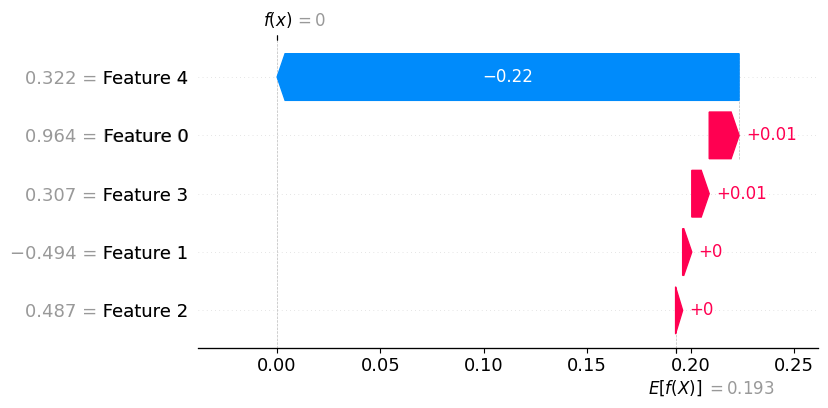

In [30]:
shap.plots.waterfall(shap_values[0])

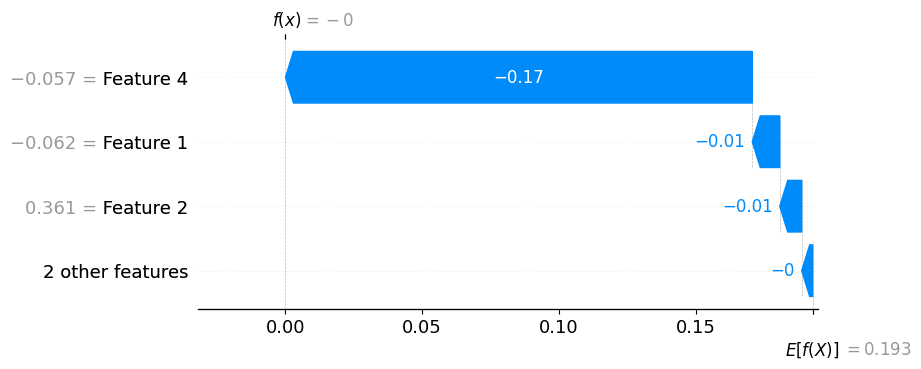

In [31]:
shap.plots.waterfall(shap_values[1], max_display=4)

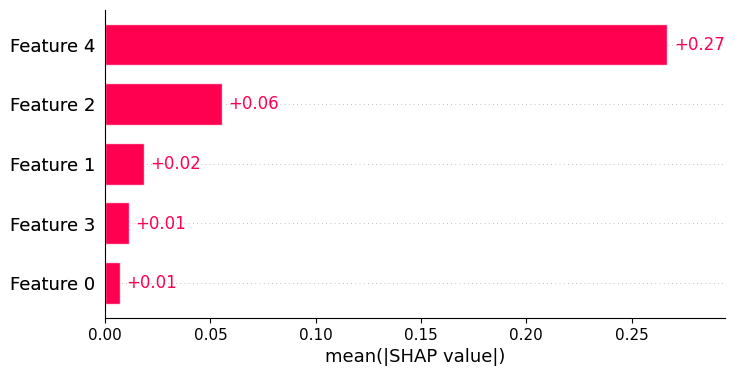

In [32]:
shap.plots.bar(shap_values)

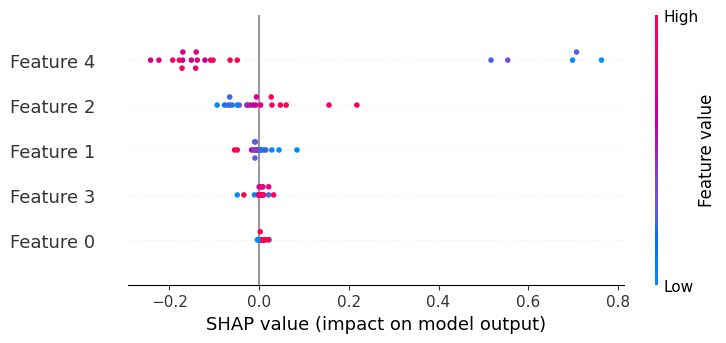

In [33]:
shap.plots.beeswarm(shap_values)